In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import confusion_matrix
from tensorflow import keras

In [ ]:
keras.utils.set_random_seed(812)

In [ ]:
# Specify the uploaded zip file name
zip_file_name = "Data_axial.zip"

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("/content")  # Extract to /content directory

# List the contents of the current directory
print(os.listdir("/content"))

['.config', 'Data_axial', 'Data_axial.zip', 'sample_data']


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/Data_axial/Training',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size= IMG_SIZE,
  batch_size= BATCH_SIZE)

Found 1078 files belonging to 4 classes.
Using 863 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/Data_axial/Training',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size= IMG_SIZE,
  batch_size= BATCH_SIZE)

Found 1078 files belonging to 4 classes.
Using 215 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['glioma_axial', 'meningioma_axial', 'no_tumor_axial', 'pituitary_axial']


In [ ]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
base_model = tf.keras.applications.VGG19(include_top=False,
                                         weights="imagenet",
                                         input_shape=IMG_SHAPE)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
base_model.trainable = False

In [ ]:
model_VGG = tf.keras.models.Sequential()
model_VGG.add(tf.keras.layers.Rescaling(scale=1./255, offset=0.0))
model_VGG.add(base_model)
model_VGG.add(tf.keras.layers.Flatten())
model_VGG.add(tf.keras.layers.Dense(512, activation='relu'))
model_VGG.add(tf.keras.layers.Dense(4, activation='softmax'))

In [ ]:
model_VGG.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_VGG = model_VGG.fit(train_ds, validation_data=val_ds, epochs = 10)

Epoch 1/10
27/27 [==============================] - 13s 273ms/step - loss: 1.8738 - accuracy: 0.5319 - val_loss: 0.9130 - val_accuracy: 0.6279
Epoch 2/10
27/27 [==============================] - 2s 67ms/step - loss: 0.4926 - accuracy: 0.8019 - val_loss: 0.4891 - val_accuracy: 0.8000
Epoch 3/10
27/27 [==============================] - 2s 67ms/step - loss: 0.3683 - accuracy: 0.8470 - val_loss: 0.4545 - val_accuracy: 0.8465
Epoch 4/10
27/27 [==============================] - 2s 68ms/step - loss: 0.3666 - accuracy: 0.8552 - val_loss: 0.4371 - val_accuracy: 0.8233
Epoch 5/10
27/27 [==============================] - 2s 68ms/step - loss: 0.2776 - accuracy: 0.8980 - val_loss: 0.4934 - val_accuracy: 0.8047
Epoch 6/10
27/27 [==============================] - 2s 73ms/step - loss: 0.2143 - accuracy: 0.9258 - val_loss: 0.3677 - val_accuracy: 0.8558
Epoch 7/10
27/27 [==============================] - 3s 77ms/step - loss: 0.1932 - accuracy: 0.9421 - val_loss: 0.3668 - val_accuracy: 0.8558
Epoch 8/10


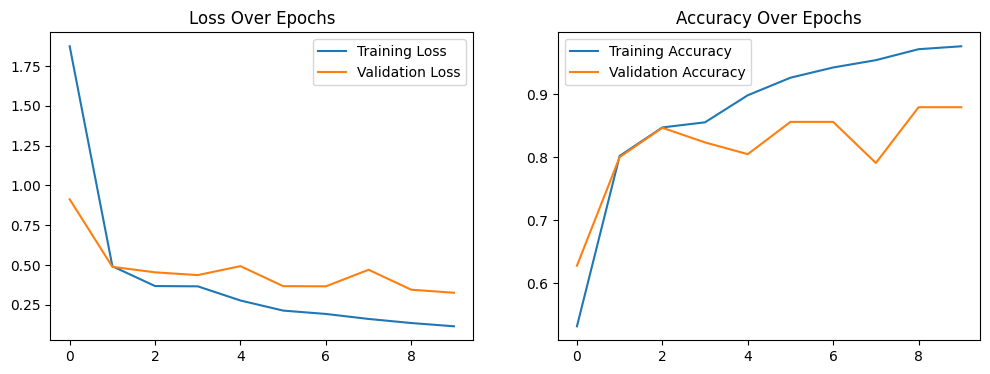

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_VGG.history['loss'], label='Training Loss')
plt.plot(history_VGG.history['val_loss'], label='Validation Loss')
plt.legend()
#plt.xticks(range(len(history.history['loss'])))
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_VGG.history['accuracy'], label='Training Accuracy')
plt.plot(history_VGG.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

#plt.xticks(range(len(history.history['accuracy'])))

plt.show()

In [ ]:
predictions = model_VGG.predict(train_ds)

27/27 [==============================] - 2s 67ms/step


In [ ]:
predicted_categories = tf.argmax(predictions, axis=1)

In [ ]:
true_categories = tf.concat([y for x, y in train_ds], axis=0)

In [ ]:
conf_matrix = confusion_matrix(predicted_categories, true_categories)

Text(0.5, 69.7222222222222, 'Predicted')

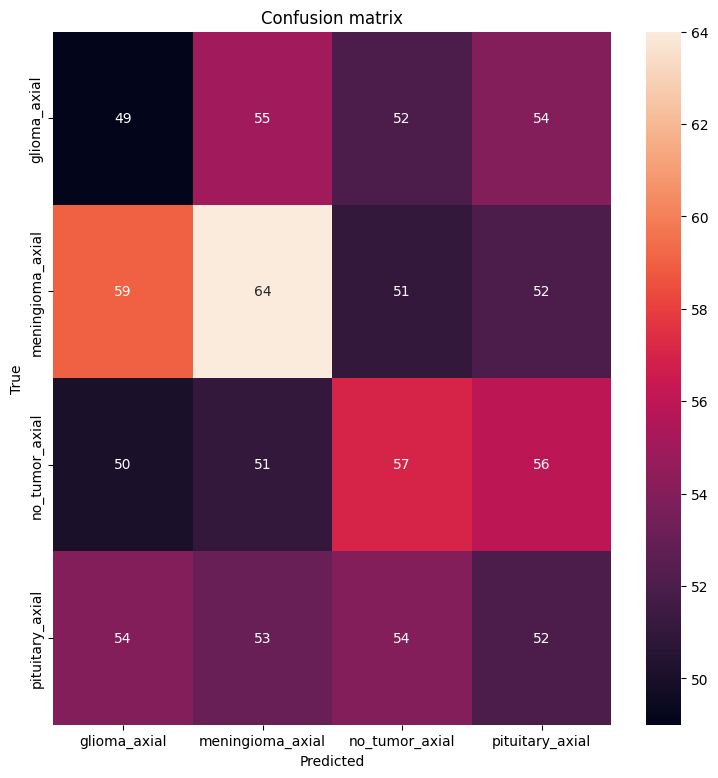

In [ ]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
sns.heatmap(conf_matrix, annot=True,fmt='.0f')
plt.title('Confusion matrix')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.ylabel('True')
plt.xlabel('Predicted')

# **Test: Compiling with a learning rate - that's funny**

In [ ]:
base_learning_rate = 0.0001
model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
history_VGG_lr = model_VGG.fit(train_ds, validation_data=val_ds, epochs = 10)

Epoch 1/10
27/27 [==============================] - 4s 106ms/step - loss: 0.0986 - accuracy: 0.2584 - val_loss: 0.2912 - val_accuracy: 0.3256
Epoch 2/10
27/27 [==============================] - 3s 84ms/step - loss: 0.0927 - accuracy: 0.2584 - val_loss: 0.3007 - val_accuracy: 0.3256
Epoch 3/10
27/27 [==============================] - 2s 71ms/step - loss: 0.0825 - accuracy: 0.2584 - val_loss: 0.2970 - val_accuracy: 0.3256
Epoch 4/10
27/27 [==============================] - 2s 68ms/step - loss: 0.0834 - accuracy: 0.2584 - val_loss: 0.2949 - val_accuracy: 0.3256
Epoch 5/10
27/27 [==============================] - 2s 67ms/step - loss: 0.0779 - accuracy: 0.2584 - val_loss: 0.2981 - val_accuracy: 0.3256
Epoch 6/10
27/27 [==============================] - 3s 90ms/step - loss: 0.0792 - accuracy: 0.2584 - val_loss: 0.3166 - val_accuracy: 0.3256
Epoch 7/10
27/27 [==============================] - 2s 76ms/step - loss: 0.0813 - accuracy: 0.2584 - val_loss: 0.3396 - val_accuracy: 0.3256
Epoch 8/10
2

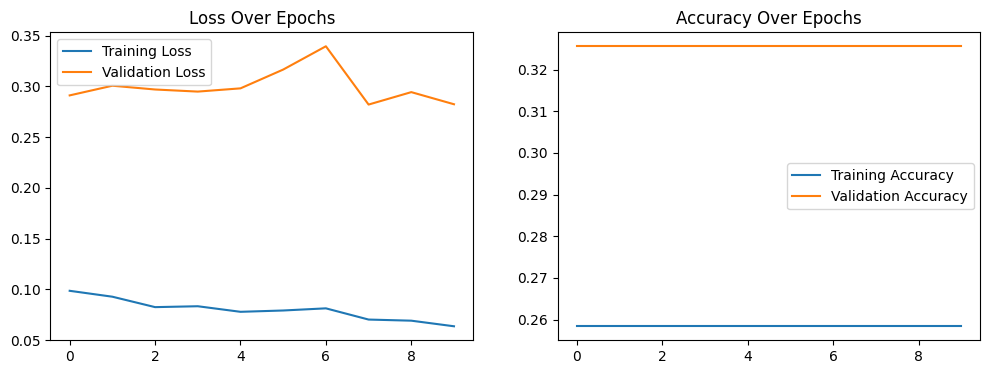

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_VGG_lr.history['loss'], label='Training Loss')
plt.plot(history_VGG_lr.history['val_loss'], label='Validation Loss')
plt.legend()
#plt.xticks(range(len(history.history['loss'])))
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_VGG_lr.history['accuracy'], label='Training Accuracy')
plt.plot(history_VGG_lr.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

#plt.xticks(range(len(history.history['accuracy'])))

plt.show()